## Transversal Error Corrected After Every Gate Qubit Adder

In [2]:
%load_ext autoreload
%autoreload 2

import qiskit
import common
import gates
import constants


In [3]:
def logical_register(name: str) -> list:
    return [qiskit.QuantumRegister(1, name), qiskit.QuantumRegister(8, f"{name}l")]

# Create quantum registers
creq_cat = []
areq_cat = []
breq_cat = []
for i in range(constants.bits):
    creq_cat.append(logical_register(f"c{i}"))
    areq_cat.append(logical_register(f"a{i}"))
    breq_cat.append(logical_register(f"b{i}"))
breq_cat.append(logical_register(f"b{constants.bits}"))


# Combine quantum registers into a single list
req_cat = []
for i in range(constants.bits):
    req_cat.extend(creq_cat[i])
    req_cat.extend(areq_cat[i])
    req_cat.extend(breq_cat[i])
req_cat.extend(breq_cat[constants.bits])

classical_req_cat = qiskit.ClassicalRegister(constants.bits + 1, "result")
qc_cat = qiskit.QuantumCircuit(*req_cat, classical_req_cat)

# Add shor setup
for i in range(constants.bits):
    qc_cat = gates.add_shor_setup(qc_cat, creq_cat[i])
    qc_cat = gates.add_shor_setup(qc_cat, areq_cat[i])
    qc_cat = gates.add_shor_setup(qc_cat, breq_cat[i])
qc_cat = gates.add_shor_setup(qc_cat, breq_cat[constants.bits])

# Add X gates to set the initial values
for i in range(constants.bits):
    if constants.a[::-1][i] == "1":
        qc_cat = gates.add_z(qc_cat, areq_cat[i])
        qc_cat = gates.add_shor_teardown(qc_cat, areq_cat[i])
    if constants.b[::-1][i] == "1":
        qc_cat = gates.add_z(qc_cat, breq_cat[i])
        qc_cat = gates.add_shor_teardown(qc_cat, breq_cat[i])


# Add the carry and sum gates
for i in range(constants.bits):
    if i != constants.bits - 1:
        qc_cat = gates.add_carry(qc_cat, creq_cat[i], areq_cat[i], breq_cat[i], creq_cat[i + 1])

        qc_cat = gates.add_shor_teardown(qc_cat, creq_cat[i])
        qc_cat = gates.add_shor_teardown(qc_cat, areq_cat[i])
        qc_cat = gates.add_shor_teardown(qc_cat, breq_cat[i])
        qc_cat = gates.add_shor_teardown(qc_cat, creq_cat[i + 1])
    else:
        qc_cat = gates.add_carry(qc_cat, creq_cat[i], areq_cat[i], breq_cat[i], breq_cat[i + 1])
        qc_cat = gates.add_cx(qc_cat, areq_cat[i], breq_cat[i])

        qc_cat = gates.add_shor_teardown(qc_cat, creq_cat[i])
        qc_cat = gates.add_shor_teardown(qc_cat, areq_cat[i])
        qc_cat = gates.add_shor_teardown(qc_cat, breq_cat[i])
        qc_cat = gates.add_shor_teardown(qc_cat, breq_cat[i + 1])

for i in reversed(range(constants.bits)):
    qc_cat = gates.add_sum(qc_cat, creq_cat[i], areq_cat[i], breq_cat[i])

    qc_cat = gates.add_shor_teardown(qc_cat, creq_cat[i])
    qc_cat = gates.add_shor_teardown(qc_cat, areq_cat[i])
    qc_cat = gates.add_shor_teardown(qc_cat, breq_cat[i])

    if i != 0:
        qc_cat = gates.add_reverse_carry(qc_cat, creq_cat[i - 1], areq_cat[i - 1], breq_cat[i - 1], creq_cat[i])

        qc_cat = gates.add_shor_teardown(qc_cat, creq_cat[i - 1])
        qc_cat = gates.add_shor_teardown(qc_cat, areq_cat[i - 1])
        qc_cat = gates.add_shor_teardown(qc_cat, breq_cat[i - 1])
        qc_cat = gates.add_shor_teardown(qc_cat, creq_cat[i])

print(f"{qc_cat.num_qubits} qubits used")

for i in range(constants.bits + 1):
    qc_cat.measure(breq_cat[i][0], classical_req_cat[i])

# qc_cat.draw("mpl")

117 qubits used


Backend: ibm_brisbane
Most likely state: 00001


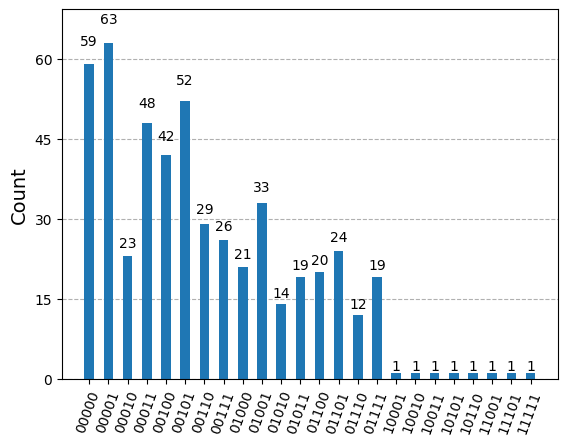

In [43]:
# raise common.StopExecution

simulator_cat = common.RealQuantumComputer(qc_cat, 512)
counts_cat = simulator_cat.run("result")
print(f"Backend: {simulator_cat.backend_name()}")
print(f"Most likely state: {simulator_cat.most_common()}")
simulator_cat.plot()